In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandahouse
import numpy as np
import hashlib #делать хэши
#import swifter #ускорение метода apply
from scipy import stats #статистика
%matplotlib inline

In [36]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20220520'
     }

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM  simulator_20220520.feed_actions 
WHERE toDate(time) between '2022-04-17' and '2022-04-23'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""
df = pandahouse.read_clickhouse(q, connection=connection)


In [28]:
def get_bootstrap_samples(data, len_sample, n_samples):
    indices = np.random.randint(0, len_sample, (n_samples, len(data)))
    samples = data[indices]
    return samples

Генерируем 10000 АА-тестов с подвыборками с повторением в 500 юзеров

In [37]:
df2= pd.DataFrame(columns=['p_value'])
for i in range(10000):
    p_val=stats.ttest_ind(
                            df[df.exp_group == 2].ctr.sample(500, replace=True).tolist(),
                            df[df.exp_group == 3].ctr.sample(500, replace=True).tolist(),
                                            equal_var=False)[1]
    
    
    
    df2= df2.append({'p_value': p_val}, ignore_index=True)
    

гистограмма распределения получившихся 10000 p-values.

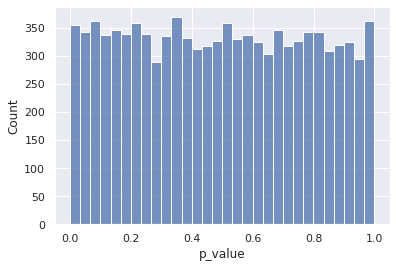

In [38]:
#sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df2['p_value'],  
              palette = ['b'],
                     bins=30)

%тестов, где p-value <0.05 составляет

In [71]:
p_val_rate=df2[df2['p_value']<0.05].count()/len(df2['p_value'])*100

In [76]:
print("%тестов, где p-value <0.05 составляет",round(p_val_rate[0],2),'%')

%тестов, где p-value <0.05 составляет 5.32 %


Вывод по проведенному АА-тесту: % тестов, где  p-value <0.05 только на 0.32%  выше заданного порога в 5%. 
Т.е прибизительно только в 5% случаев у нас получились статистически знаимые различия между 2 и 3 группой. 
Визуально распределение также получилось относительно равномерным. Считаю, что система сплитования работает корректно. 